In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus

In [2]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# DATA IMPORT

In [4]:
df=pd.read_csv(r'../data/training.csv')


In [5]:
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['Time']= df['date'].apply(lambda x:x.time())
df['Date']= df['date'].apply(lambda x:x.date())
df['Time'] =  pd.to_timedelta(str(x) for x in df['Time'])
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop('date', axis=1, inplace=True)

df.drop('HumidityRatio',inplace=True,axis=1)
df=df[df['Light']<10000] 

In [6]:
df.drop('Unnamed: 0',inplace=True,axis=1)

In [7]:
test=pd.read_csv(r'../data/test.csv')

In [8]:
test['date'] =  pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
test['Time']= test['date'].apply(lambda x:x.time())
test['Date']= test['date'].apply(lambda x:x.date())
test['Time'] =  pd.to_timedelta(str(x) for x in test['Time'])
test['Date'] =  pd.to_datetime(test['Date'], format='%Y-%m-%d')
test.drop('date', axis=1, inplace=True)

test.drop('HumidityRatio',inplace=True,axis=1)

In [9]:
test.drop('Unnamed: 0',inplace=True,axis=1)

# DATA PREPARTAION

Dovendo fare la classification col decion tree voglio fare One Hot Encoding (getDummies) con gli attributi tmporali.

Perciò trasformo data in Holiday 1 o 0 in base al giorno della settimana 

In [10]:
#weekday() restituisce il giorno della settimana in formato numerico 
#con lo 0 corrispondente al lunedi e il 6 alla domenica

df['Holiday'] = df['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )
test['Holiday'] = test['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )

Invece per l' orario lo separo prima in 24 intervalli in base all' ora
poi uso get dummies e aggiungo H prima del valore

In [11]:
df['Hour']= df['Time'].apply(lambda x:'H'+ str(x)[7:9])
#df['Date']= df['Date'].apply(lambda x:str(x)[8:10])

test['Hour']= test['Time'].apply(lambda x:'H'+ str(x)[7:9])
#test['Date']= test['Date'].apply(lambda x:str(x)[8:10])

In [12]:
df_enc=df.copy()
test_enc=test.copy()

In [13]:
df_enc = pd.get_dummies( df_enc, columns = ['Hour'])
test_enc = pd.get_dummies( test_enc, columns = ['Hour'])

In [14]:
df_enc.drop('Time',axis=1,inplace=True)
df_enc.drop('Date',axis=1,inplace=True)
test_enc.drop('Time',axis=1,inplace=True)
test_enc.drop('Date',axis=1,inplace=True)

In [15]:
df_enc

,Temperature,Humidity,Light,CO2,Occupancy,Holiday,Hour_H00,Hour_H01,Hour_H02,Hour_H03,...,Hour_H14,Hour_H15,Hour_H16,Hour_H17,Hour_H18,Hour_H19,Hour_H20,Hour_H21,Hour_H22,Hour_H23
0,20.70,24.8400,0.00,587.50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19.79,35.2000,0.00,524.50,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,20.89,25.2000,0.00,557.20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,22.20,24.3340,429.50,913.00,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,22.08,28.3700,544.20,1198.60,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14386,20.60,26.8900,0.00,508.00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14387,21.20,25.3925,454.75,782.00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14388,19.29,26.8900,0.00,465.50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14389,21.70,20.8900,433.00,802.25,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [16]:
for col in df_enc.columns[1:]:
    if col not in test_enc.columns[1:]:
        test_enc[col]=0
for col in test_enc.columns[1:]:
    if col not in df_enc.columns[1:]:
        df_enc[col]=0

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [18]:
attributes = [col for col in df_enc.columns if col != 'Occupancy']

X_train =df_enc[attributes].values
y_train=df_enc['Occupancy'].values
X_test=test_enc[attributes].values
y_test=test_enc['Occupancy'].values

# DECICION TREE CLASSIFICATION

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
clf = DecisionTreeClassifier(min_samples_leaf=100, max_depth=7, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

y_score=clf.predict_proba(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.9899481193255513
F1-score [0.99343776 0.97853186]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.96      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [21]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=['Empty','Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [22]:
clf = DecisionTreeClassifier(min_samples_leaf=100, max_depth=1, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.9899481193255513
F1-score [0.99343776 0.97853186]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.96      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



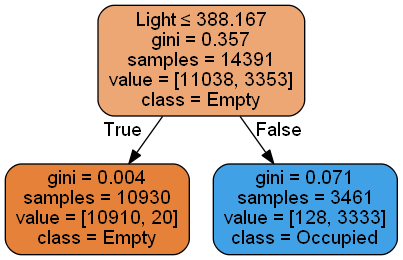

In [35]:

dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=['Empty','Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=5)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

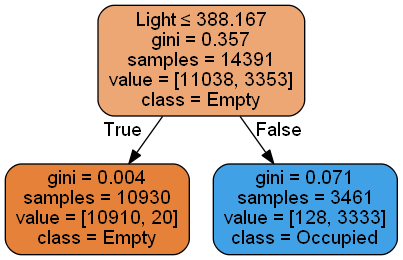

In [24]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=['Empty','Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=1)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [23]:
clf = DecisionTreeClassifier(min_samples_leaf=3, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.9928664072632944
F1-score [0.99535767 0.98460462]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4747
           1       0.98      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



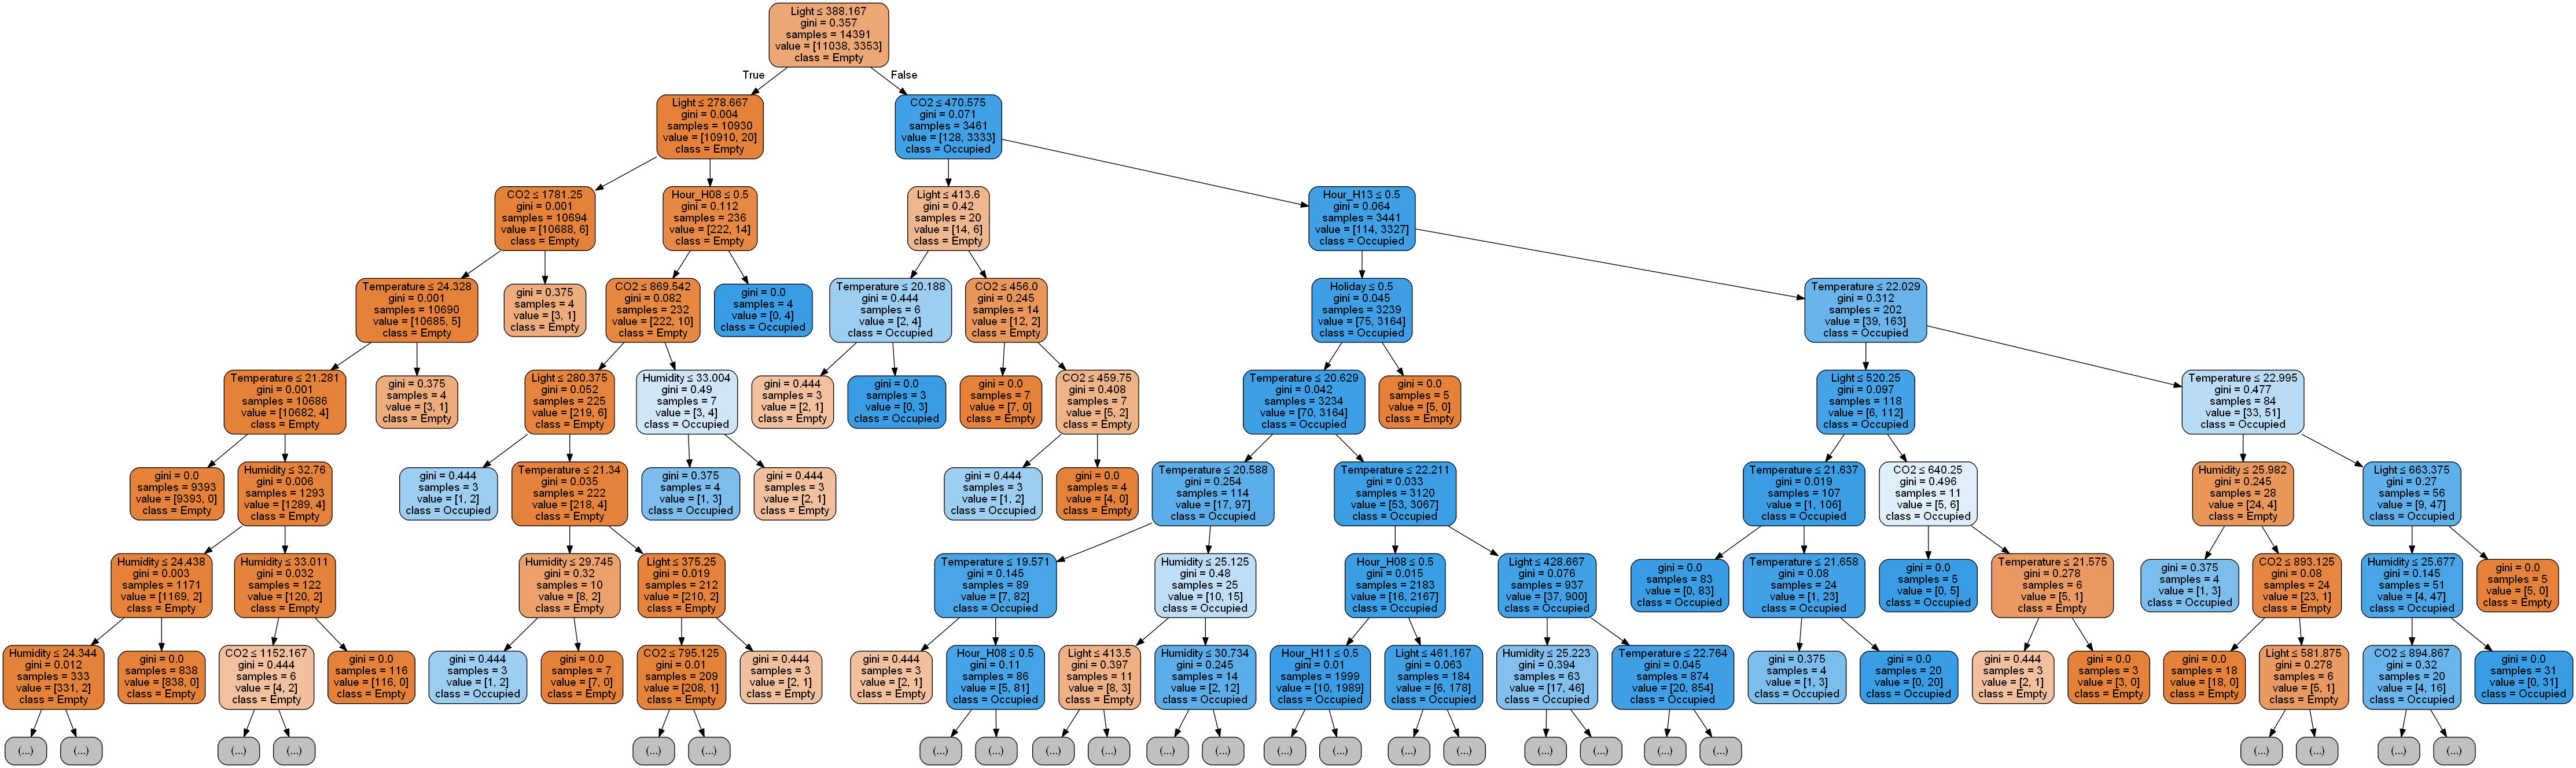

In [24]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=['Empty','Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=7)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [37]:
X=df[['Temperature','CO2','Light','Humidity']]
XT=test[['Temperature','CO2','Light','Humidity']]

In [38]:
clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=20, random_state=42)
clf.fit(X, y_train)

y_pred1 = clf.predict(XT)

print('Accuracy %s' % accuracy_score(y_test, y_pred1))
print('F1-score %s' % f1_score(y_test, y_pred1, average=None))
print(classification_report(y_test, y_pred1))

Accuracy 0.9910830090791181
F1-score [0.99419892 0.98073555]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4747
           1       0.98      0.99      0.98      1421

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



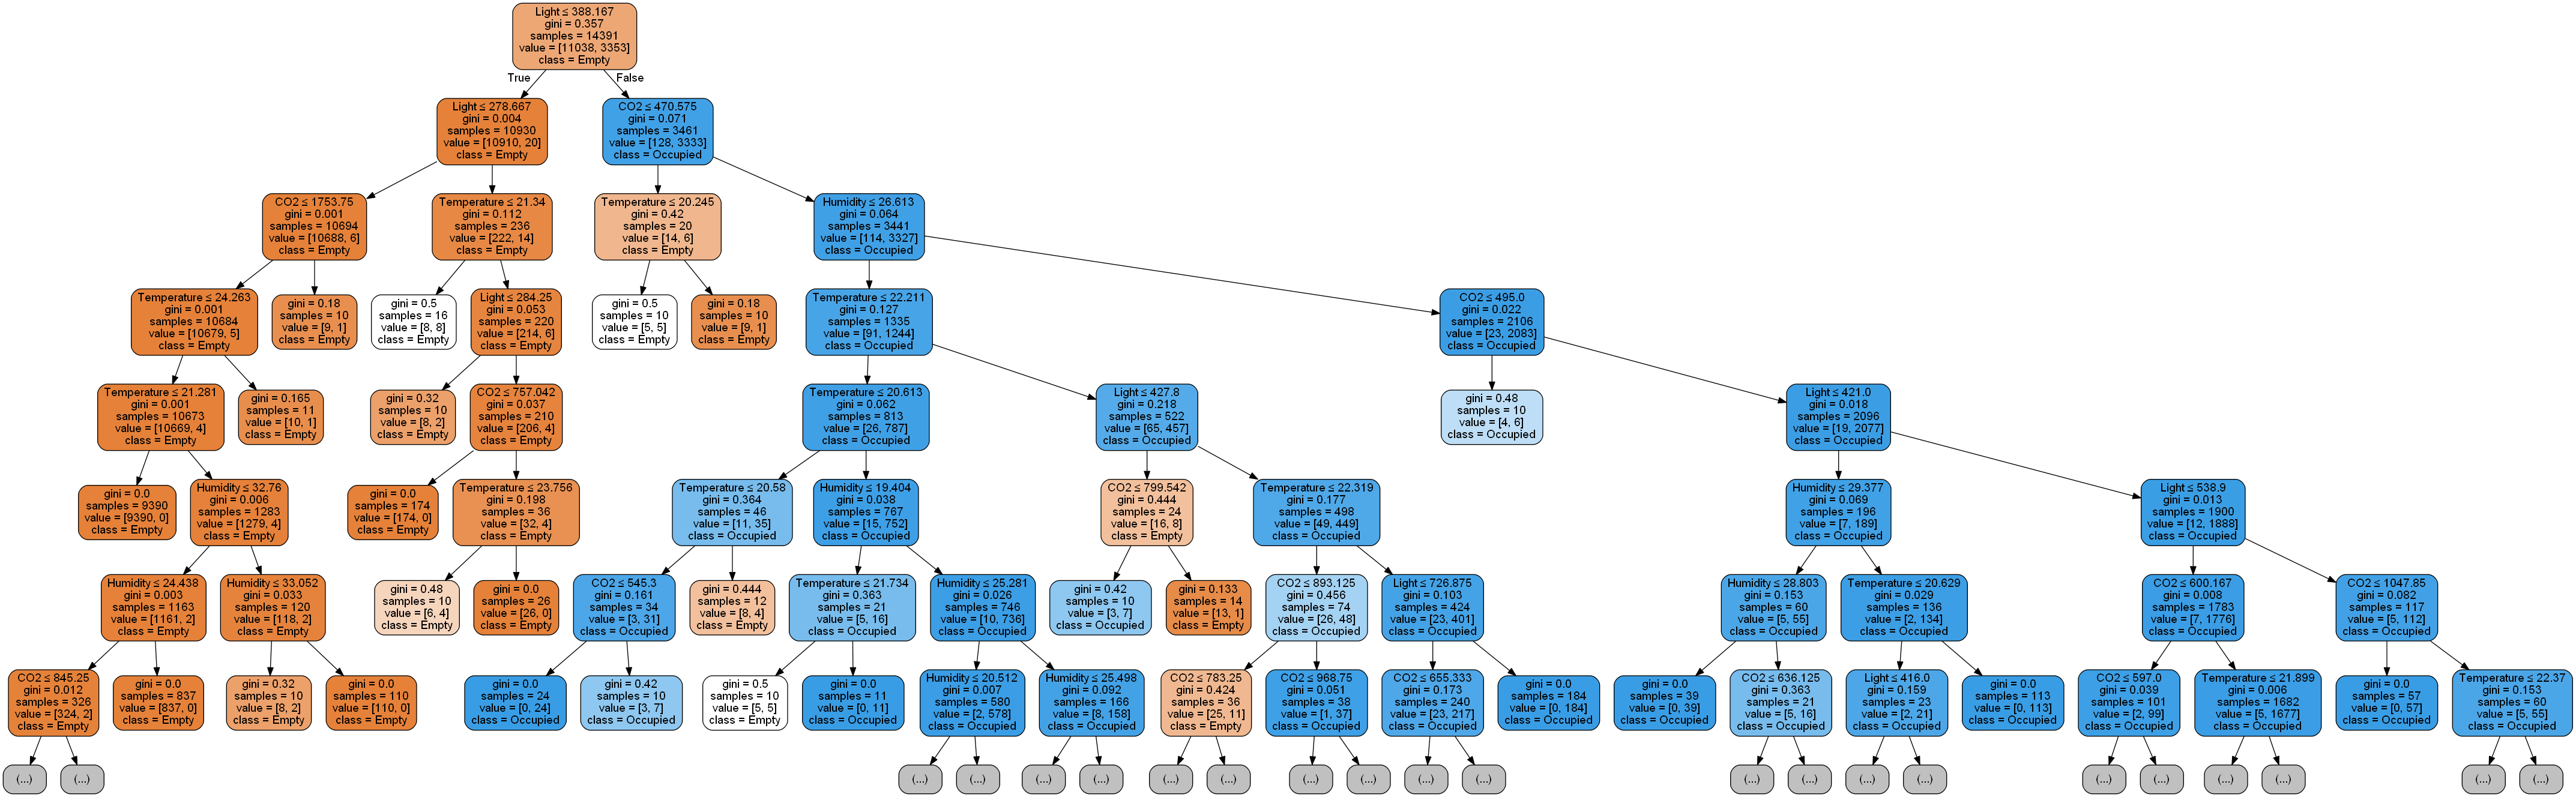

In [39]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=['Temperature','CO2','Light','Humidity'], 
                                class_names=['Empty','Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=7)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [40]:
df['Occupancy'].value_counts()

0    11038
1     3353
Name: Occupancy, dtype: int64

# EVALUATION

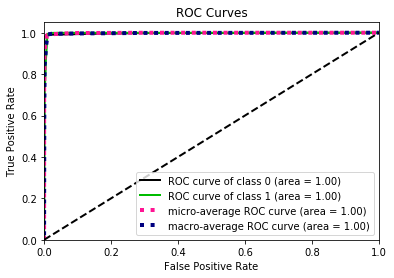

In [43]:
plot_roc(y_test, y_score)
plt.show()

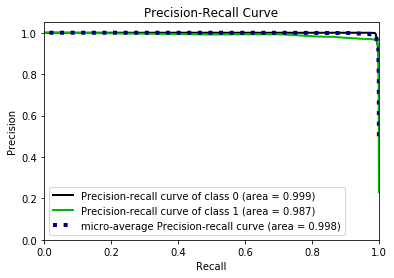

In [44]:
plot_precision_recall(y_test, y_score)
plt.show()

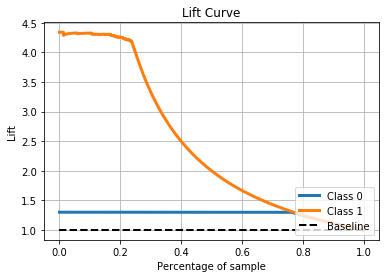

In [45]:
plot_lift_curve(y_test, y_score)
plt.show()

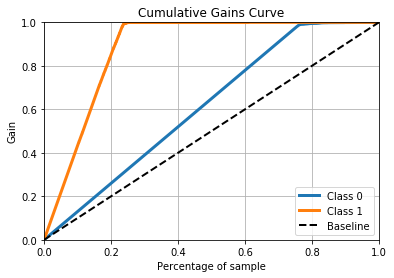

In [46]:
plot_cumulative_gain(y_test, y_score)
plt.show()